# Time Series Forecasting - Air Passengers

In [1]:
!pip install numpy==2.1.2 pandas==2.2.3 matplotlib==3.9.2 statsmodels==0.14.4

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/satishgunjal/datasets/master/Time_Series_AirPassengers.csv')
df['Date'] = pd.to_datetime(df.Month, format="%Y-%m")
df = df.set_index("Date")
del df["Month"]
df.head()

,Passengers
Date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


<Axes: xlabel='Date'>

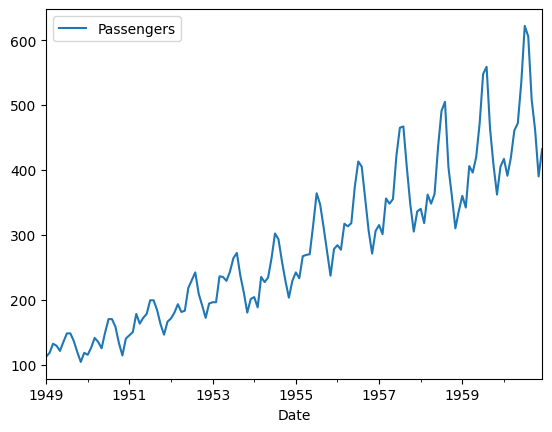

In [4]:
df.plot()

<Axes: title={'center': 'Passengers'}, xlabel='month'>

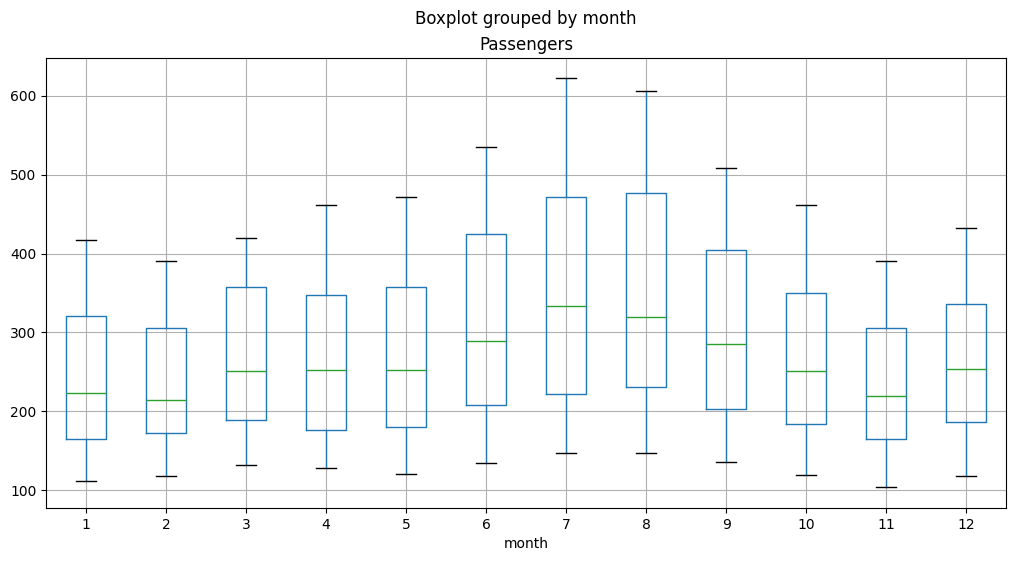

In [5]:
df.assign(month=df.index.month).boxplot(column='Passengers', by='month', figsize=(12, 6))

In [6]:
def check_stationarity(series):
    result = adfuller(series.values)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")


check_stationarity(df["Passengers"])

ADF Statistic: 0.815369
p-value: 0.991880
Critical Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579
Non-stationary


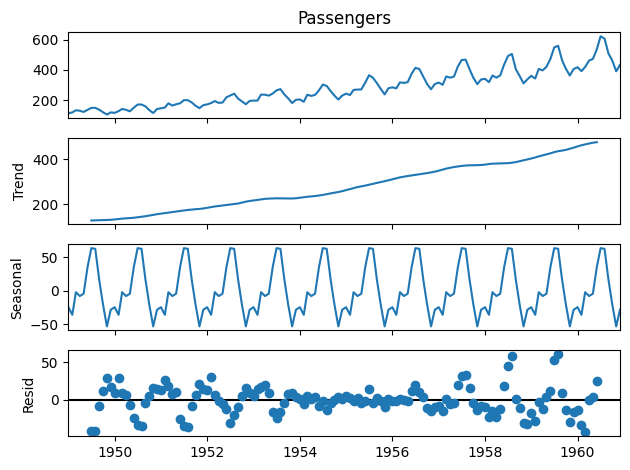

In [7]:
decomposition_add = seasonal_decompose(df["Passengers"], model="additive", period=12)
decomposition_add.plot()
plt.show()

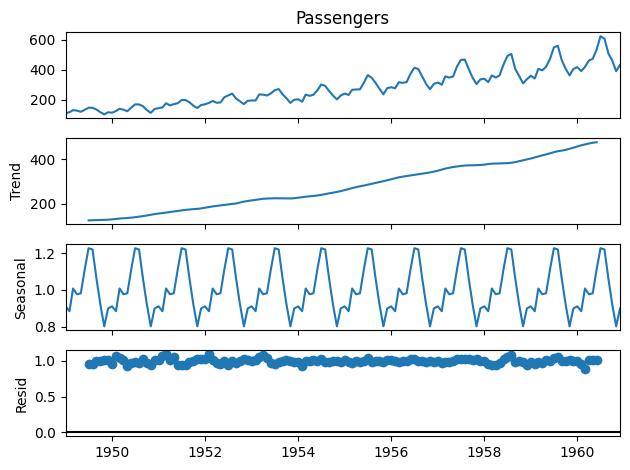

In [8]:
decomposition_mul = seasonal_decompose(df["Passengers"], model="multiplicative", period=12)
decomposition_mul.plot()
plt.show()

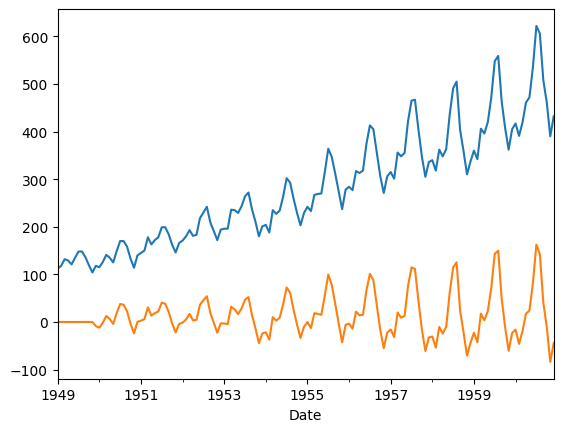

In [9]:
rolling_mean = df["Passengers"].rolling(12).mean()
df["Detrended"] = df["Passengers"] - rolling_mean
df["Detrended"] = df["Detrended"].fillna(0)
df["Passengers"].plot()
df["Detrended"].plot()
plt.show()

In [10]:
check_stationarity(df["Detrended"])

ADF Statistic: -3.253978
p-value: 0.017065
Critical Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579
Stationary


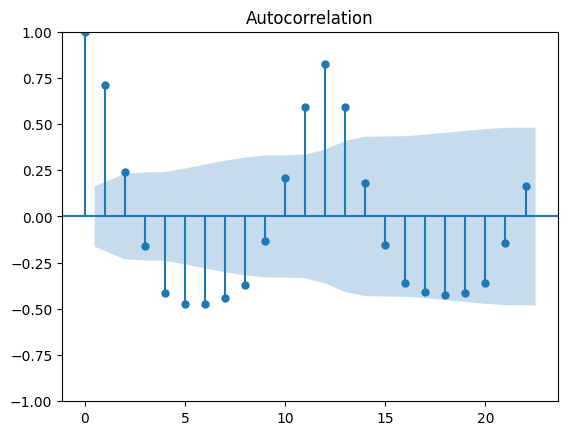

In [11]:
plot_acf(df["Detrended"])
plt.show()

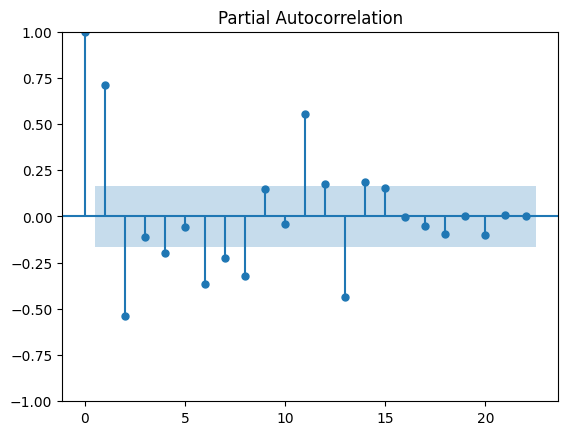

In [12]:
plot_pacf(df["Detrended"])
plt.show()

In [13]:
samples = df["Detrended"].copy()
n = len(samples)
train_size = int(n*0.9)
train_samples = samples[:train_size].copy()
test_samples = samples[train_size:].copy()

p, d, q = 8, 0, 4
model = ARIMA(train_samples, order=(p, d, q))
fitted_model = model.fit()
print(fitted_model.summary())

/opt/conda/envs/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/conda/envs/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/conda/envs/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/conda/envs/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/conda/envs/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarnin

                               SARIMAX Results                                
Dep. Variable:              Detrended   No. Observations:                  129
Model:                 ARIMA(8, 0, 4)   Log Likelihood                -534.974
Date:                Wed, 06 Nov 2024   AIC                           1097.947
Time:                        11:34:36   BIC                           1137.985
Sample:                    01-01-1949   HQIC                          1114.215
                         - 09-01-1959                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.5680      1.509      8.994      0.000      10.611      16.525
ar.L1          0.3607      0.084      4.276      0.000       0.195       0.526
ar.L2         -0.0575      0.092     -0.624      0.5

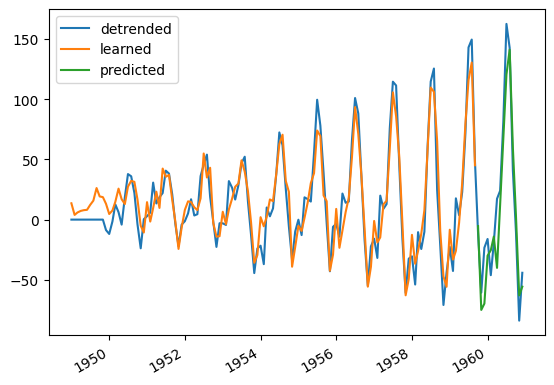

In [14]:
forecast = fitted_model.forecast(steps=len(test_samples))
forecast.index = test_samples.index
plt.plot(samples)
fitted_model.predict().plot()
plt.plot(forecast)
plt.legend(["detrended","learned","predicted"])
plt.show()

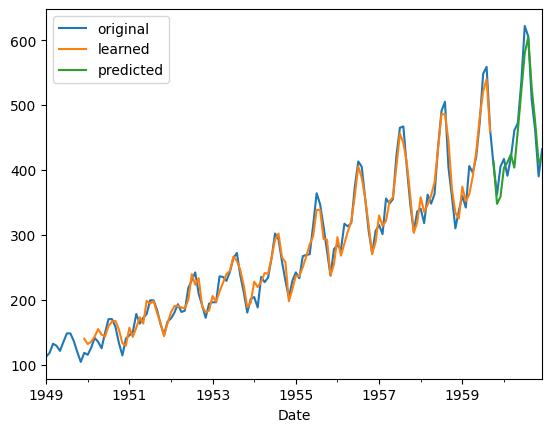

In [15]:
df.Passengers.plot()
learned = fitted_model.predict() + rolling_mean
learned.plot()
predicted = forecast + rolling_mean[-len(test_samples):]
predicted.plot()
plt.legend(["original","learned","predicted"])
plt.show()

In [20]:
mae_train = np.abs((train_samples+rolling_mean[:len(train_samples)]) - learned).mean()
mae_test = (np.abs((test_samples+rolling_mean[-len(test_samples):]) - predicted)).mean()
print(f"MAE (train): {mae_train}, MAE (test): {mae_test}")

MAE (train): 12.093841619615231, MAE (test): 19.816234926158494
